In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import glob

In [2]:
all_centrality_files = sorted(glob.glob('results/centrality/**/*.pkl', recursive=True))

In [3]:
stations_df = pd.read_csv('grp_stations.csv', index_col=0)
index = stations_df['Id'].astype(str)

In [4]:
import pandas as pd
import numpy as np

def get_empty_df():

    # Define your structure
    centralities = ['strength_in', 'strength_out', 'eigenvector_in', 'eigenvector_out', 'betweenness']
    usertypes = ['members', 'casuals', 'years']
    nettypes = ['months', 'temp']
    month_ids = list(range(1, 13))      
    temperature_ids = list(range(6)) 
    
    # Build the column MultiIndex
    cols = []
    
    for c in centralities:
        for u in usertypes:
            for i in month_ids:
                cols.append((c, u, 'months', i))
            for i in temperature_ids:
                cols.append((c, u, 'temp', i))
    
    # Create the MultiIndex
    multi_index = pd.MultiIndex.from_tuples(cols, names=['centrality', 'usertype', 'nettype', 'index'])
    
    # Create dummy data
    df = pd.DataFrame(index=index, columns=multi_index)
    df = df.sort_index(axis=1)

    return df

# RQ1

## Z-scores

In [464]:
def get_z_score(x, nulls):

    # Mean and std of null model measurements
    mu = np.mean(nulls)
    sigma = np.std(nulls, ddof=1)  # ddof=1 for sample standard deviation

    if sigma == 0:
        if x == mu:
            return 0 
        else:
            return np.inf * np.sign(x - mu) 
    
    # Compute z-score
    z_score = (x - mu) / sigma

    return z_score

In [11]:
import pandas as pd
import numpy as np

# Define your structure
centralities = ['strength_in', 'strength_out', 'eigenvector_in', 'eigenvector_out', 'betweenness']
usertypes = ['members', 'casuals', 'years']
nettypes = ['months', 'temp']
month_ids = list(range(1, 13))      
temperature_ids = list(range(6)) 

# Build the column MultiIndex
cols = []

for c in centralities:
    for u in usertypes:
        for i in month_ids:
            cols.append((c, u, 'months', i))
        for i in temperature_ids:
            cols.append((c, u, 'temp', i))

# Create the MultiIndex
multi_index = pd.MultiIndex.from_tuples(cols, names=['centrality', 'usertype', 'nettype', 'index'])

# Create dummy data
df = pd.DataFrame(index=index, columns=multi_index)
df = df.sort_index(axis=1)

# Preview
df.head()

centrality betweenness                                               ...  \
usertype       casuals                                               ...   
nettype         months                                               ...   
index               1    2    3    4    5    6    7    8    9    10  ...   
Id                                                                   ...   
7051               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
7143               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
7113               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
7077               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
7079               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

centrality strength_out                                               
usertype          years                                               
nettype          months                temp                           
index                9    10   11   12   0    1    2    3    4    5   
Id                                                                    
7051                NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7143                NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7113                NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7077                NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7079                NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 270 columns]

In [14]:
def get_strength_z_scores(result):
    
    nodes = list(result['orig']['in'].keys())

    # in calculation

    obs_values_in, null_values_in = zip(*[(result['orig']['in'][node], result['nulls']['in'][node]) for node in nodes])

    z_scores_in = list(map(get_z_score, obs_values_in, null_values_in))

    # out calculation

    obs_values_out, null_values_out = zip(*[(result['orig']['out'][node], result['nulls']['out'][node]) for node in nodes])

    z_scores_out = list(map(get_z_score, obs_values_out, null_values_out))

    return nodes, z_scores_in, z_scores_out

In [15]:
def get_betweenness_z_scores(result):
    
    nodes = list(result['orig'].keys())

    obs_values, null_values = zip(*[(result['orig'][node], result['nulls'][node]) for node in nodes])

    z_scores = list(map(get_z_score, obs_values, null_values))

    return nodes, z_scores

In [172]:
import itertools
import os
import re
from tqdm.notebook import tqdm

usertypes = ['members', 'casuals', 'years']
nettypes = ['months', 'temp']
centralities = ['strength', 'eigenvector', 'betweenness']

file_pattern = re.compile('network(?:-temp)?-(\d{1,2})\.pkl')

for folders in tqdm(list(itertools.product(centralities, usertypes, nettypes))):

    centralitytype, usertype, nettype = folders

    folder_path = os.path.join('results','centrality',*folders)

    files = glob.glob(os.path.join(folder_path, '*.pkl'))

    for file in files:
        index_num = int(file_pattern.search(file).group(1))

        with open(file, 'rb') as f:
            result = pickle.load(f)

        if centralitytype == 'betweenness':
            nodes, z_scores = get_betweenness_z_scores(result)
            df.loc[nodes, pd.IndexSlice[centralitytype, usertype, nettype, index_num]] = z_scores
        else:
            nodes, z_scores_in, z_scores_out = get_strength_z_scores(result)
            df.loc[nodes, pd.IndexSlice[centralitytype + '_in', usertype, nettype, index_num]] = z_scores_in
            df.loc[nodes, pd.IndexSlice[centralitytype + '_out', usertype, nettype, index_num]] = z_scores_out



  0%|          | 0/18 [00:00<?, ?it/s]

In [453]:
temp_df = df.loc[:, pd.IndexSlice['strength_in', 'years', 'months', :]]
temp_df.columns = temp_df.columns.droplevel([0,1,2])
temp_temp_df = temp_df.melt(var_name='months', value_name='z_score', ignore_index=False).reset_index()

In [454]:
temp_temp_df

,Id,months,z_score
0,7051,1,0.36514
1,7143,1,0.514249
2,7113,1,0.762092
3,7077,1,0.604562
4,7079,1,0.6463
...,...,...,...
9115,7861,12,NaN
9116,7886,12,NaN
9117,7880,12,NaN
9118,7905,12,NaN


In [421]:
finite_vals = temp_temp_df['z_score'][(temp_temp_df['z_score'] != np.inf) & (temp_temp_df['z_score'] != -np.inf)]
max_val = finite_vals.max()
min_val = finite_vals.min()

temp_temp_df['z_score'] = temp_temp_df['z_score'].replace(np.inf, max_val)
temp_temp_df['z_score'] = temp_temp_df['z_score'].replace(-np.inf, min_val)

/tmp/ipykernel_85607/1680911743.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_temp_df['z_score'] = temp_temp_df['z_score'].replace(np.inf, max_val)


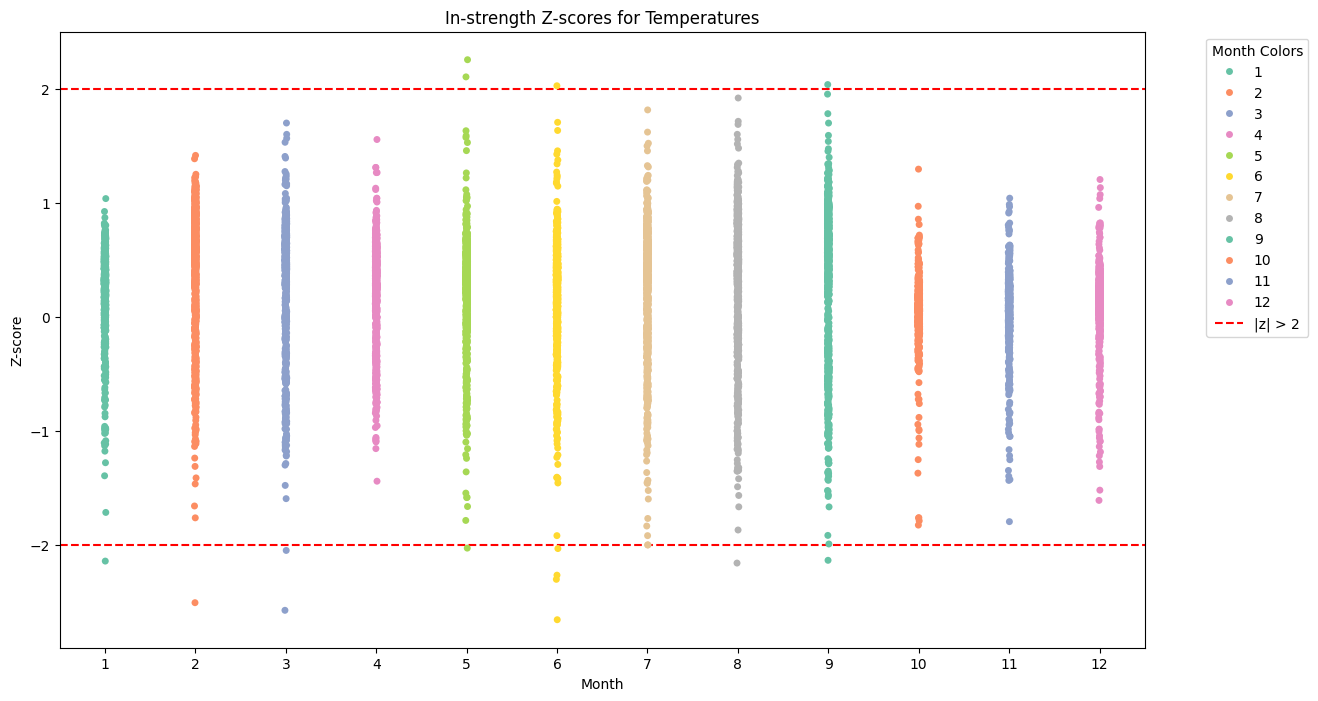

In [456]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting: Strip Plot or Box Plot for months
plt.figure(figsize=(14, 8))
sns.stripplot(x="months", y="z_score", data=temp_temp_df, jitter=0.01, hue="months", palette="Set2")
plt.axhline(y=2, color='red', linestyle='--', label="|z| > 2")
plt.axhline(y=-2, color='red', linestyle='--')
plt.title("In-strength Z-scores for Temperatures")
plt.xlabel("Month")
plt.ylabel("Z-score")
plt.legend(title="Month Colors", bbox_to_anchor=(1.05, 1), loc='upper left')

# # Label outliers (stations with |z| > 3 for example)
# outliers = temp_temp_df[temp_temp_df['z_score'].abs() > 2]
# for i, row in outliers.iterrows():
#     plt.text(row['month'], row['z_score'], row['Id'], fontsize=8, ha='center', va='bottom')

# plt.savefig('figures/RQ1/temp_strength-in.png', bbox_inches = 'tight')
plt.show()

## Randomization test

In [5]:
df = get_empty_df()

In [6]:
import numpy as np
from scipy.stats import percentileofscore

def get_percentile(x, nulls):

    return percentileofscore(nulls, x, kind='rank')

# p = 2 * min(percentile / 100, (100 - percentile) / 100)


In [7]:
def get_strength_percentile(result):
    
    nodes = list(result['orig']['in'].keys())

    # in calculation

    obs_values_in, null_values_in = zip(*[(result['orig']['in'][node], result['nulls']['in'][node]) for node in nodes])

    percentiles_in = list(map(get_percentile, obs_values_in, null_values_in))

    # out calculation

    obs_values_out, null_values_out = zip(*[(result['orig']['out'][node], result['nulls']['out'][node]) for node in nodes])

    percentiles_out = list(map(get_percentile, obs_values_out, null_values_out))

    return nodes, percentiles_in, percentiles_out

In [8]:
def get_betweenness_percentile(result):
    
    nodes = list(result['orig'].keys())

    obs_values, null_values = zip(*[(result['orig'][node], result['nulls'][node]) for node in nodes])

    percentiles = list(map(get_percentile, obs_values, null_values))

    return nodes, percentiles

In [79]:
import itertools
import os
import re
from tqdm.notebook import tqdm

usertypes = ['members', 'casuals', 'years']
nettypes = ['months', 'temp']
centralities = ['strength', 'eigenvector', 'betweenness']

file_pattern = re.compile('network(?:-temp)?-(\d{1,2})\.pkl')

for folders in tqdm(list(itertools.product(centralities, usertypes, nettypes))):

    centralitytype, usertype, nettype = folders

    folder_path = os.path.join('results','centrality',*folders)

    files = glob.glob(os.path.join(folder_path, '*.pkl'))

    for file in files:
        index_num = int(file_pattern.search(file).group(1))

        with open(file, 'rb') as f:
            result = pickle.load(f)

        if centralitytype == 'betweenness':
            nodes, percentiles = get_betweenness_percentile(result)
            df.loc[nodes, pd.IndexSlice[centralitytype, usertype, nettype, index_num]] = percentiles
        else:
            nodes, percentiles_in, percentiles_out = get_strength_percentile(result)
            df.loc[nodes, pd.IndexSlice[centralitytype + '_in', usertype, nettype, index_num]] = percentiles_in
            df.loc[nodes, pd.IndexSlice[centralitytype + '_out', usertype, nettype, index_num]] = percentiles_out



  0%|          | 0/18 [00:00<?, ?it/s]

In [80]:
temp_df = df.loc[:, pd.IndexSlice['strength_in', 'years', 'months', :]]
temp_df.columns = temp_df.columns.droplevel([0,1,2])
temp_temp_df = temp_df.melt(var_name='months', value_name='percentile', ignore_index=False).reset_index()

13 [0.05947544 0.43347904]
14 [-0.30230335 -0.74020176]
1 [0.11279691 0.93138322]
2 [-0.38123111  0.33626004]
16 [ 0.19903794 -0.8556327 ]
17 [0.75345463 0.94774298]
5 [-0.5072534   0.38424191]
6 [ 0.51811611 -0.07311945]
7 [-0.25242189  0.12707621]
8 [ 0.46859101 -0.67504731]
9 [ 0.93515092 -0.58309883]
19 [-0.82932691 -0.09989111]
20 [0.3477624  0.24702054]
21 [-0.60370033  0.83784905]
22 [ 0.83398178 -0.63167487]


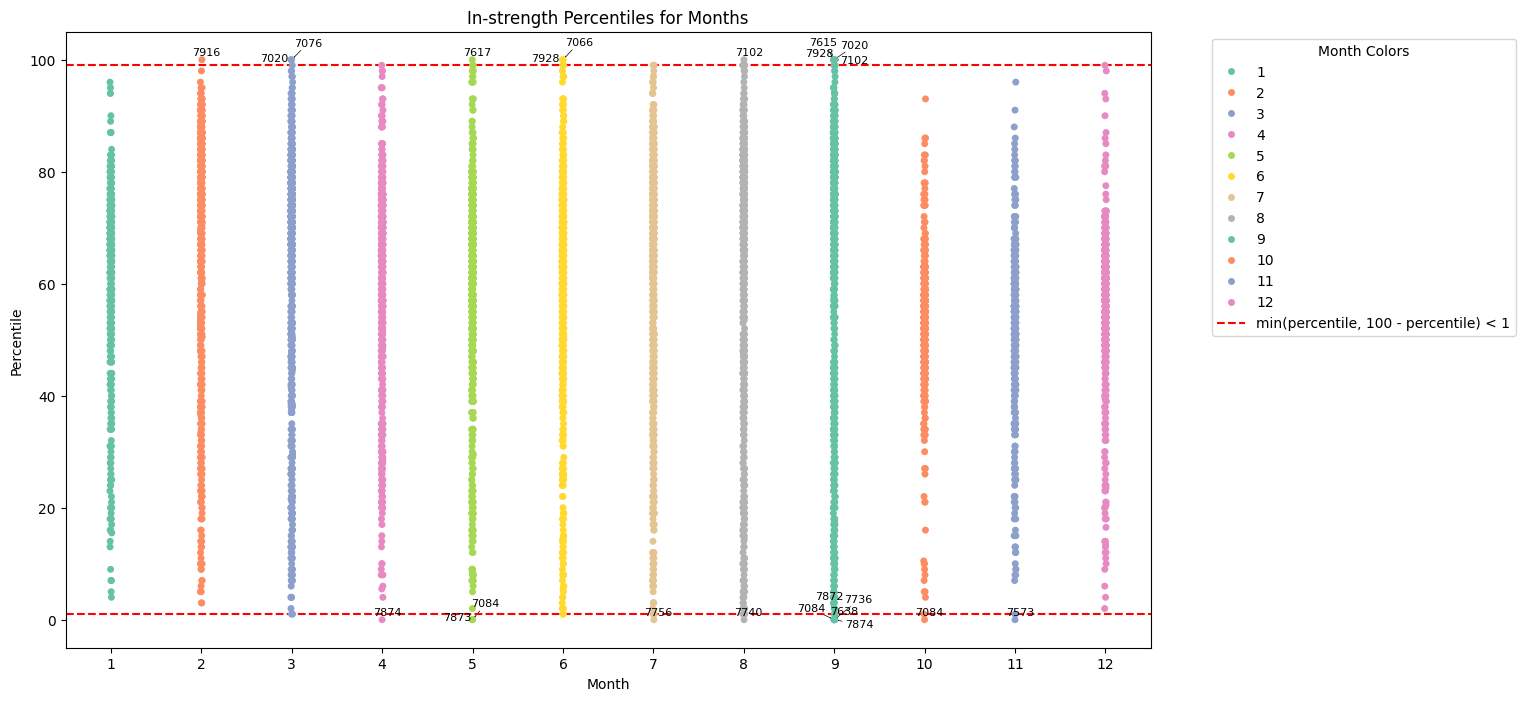

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text


# Plotting: Strip Plot or Box Plot for months
plt.figure(figsize=(14, 8))
sns.stripplot(x="months", y="percentile", data=temp_temp_df, jitter=0.01, hue="months", palette="Set2")
plt.axhline(y=99, color='red', linestyle='--', label="min(percentile, 100 - percentile) < 1")
plt.axhline(y=1, color='red', linestyle='--')
plt.title("In-strength Percentiles for Months")
plt.xlabel("Month")
plt.ylabel("Percentile")
plt.legend(title="Month Colors", bbox_to_anchor=(1.05, 1), loc='upper left')

# Label outliers (stations with |z| > 3 for example)
texts = []
outliers = pd.concat([temp_temp_df[temp_temp_df['percentile'] < 1], temp_temp_df[temp_temp_df['percentile'] > 99]], axis=0)
for i, row in outliers.iterrows():
    texts.append(plt.text(row['months'] - 1, row['percentile'], row['Id'], fontsize=8, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# plt.savefig('figures/RQ1/temp_strength-in.png', bbox_inches = 'tight')
plt.show()

In [ ]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

centralities = ['strength_in', 'strength_out', 'eigenvector_in', 'eigenvector_out', 'betweenness']
nettypes = ['months', 'temp']

for (measure, nettype) in itertools.product(centralities, nettypes):

    temp_df = df.loc[:, pd.IndexSlice[measure, 'years', nettype, :]]
    temp_df.columns = temp_df.columns.droplevel([0,1,2])
    temp_temp_df = temp_df.melt(var_name=nettype, value_name='percentile', ignore_index=False).reset_index()

    # Plotting: Strip Plot or Box Plot for months
    plt.figure(figsize=(14, 8))
    sns.stripplot(x=nettype, y="percentile", data=temp_temp_df, jitter=0.01, hue=nettype, palette="Set2")
    plt.axhline(y=99, color='red', linestyle='--', label="min(percentile, 100 - percentile) < 1")
    plt.axhline(y=1, color='red', linestyle='--')
    plt.title(f"{measure} percentiles for {nettype}")
    plt.xlabel(f"{nettype}")
    plt.ylabel("percentile")
    plt.legend(title=f"{nettype} colors", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Label outliers (stations with |z| > 3 for example)
    texts = []
    outliers = pd.concat([temp_temp_df[temp_temp_df['percentile'] < 1], temp_temp_df[temp_temp_df['percentile'] > 99]], axis=0)
    diff = 0 if nettype == 'temp' else 1
    for i, row in outliers.iterrows():
        texts.append(plt.text(row[nettype] - diff, row['percentile'], row['Id'], fontsize=8, ha='center', va='bottom'))

    try:

        text_positions = adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

    except Exception as e:

        print(f"error processing {(measure, nettype)} text adjustment.")
    
    plt.savefig(f'figures/RQ1/percentiles/{nettype}-{measure}.png', bbox_inches = 'tight')
    plt.close()    
    # plt.show()
    

## Comparing observed values with each other

In [84]:
df = get_empty_df()

In [85]:
def get_strength(result):
    
    nodes = list(result['orig']['in'].keys())

    # in calculation

    obs_values_in = [result['orig']['in'][node] for node in nodes]

    # out calculation

    obs_values_out = [result['orig']['out'][node] for node in nodes]

    return nodes, obs_values_in, obs_values_out

In [86]:
def get_betweenness(result):
    
    nodes = list(result['orig'].keys())

    obs_values = [result['orig'][node] for node in nodes]

    return nodes, obs_values

In [87]:
import itertools
import os
import re
from tqdm.notebook import tqdm

usertypes = ['members', 'casuals', 'years']
nettypes = ['months', 'temp']
centralities = ['strength', 'eigenvector', 'betweenness']

file_pattern = re.compile('network(?:-temp)?-(\d{1,2})\.pkl')

for folders in tqdm(list(itertools.product(centralities, usertypes, nettypes))):

    centralitytype, usertype, nettype = folders

    folder_path = os.path.join('results','centrality',*folders)

    files = glob.glob(os.path.join(folder_path, '*.pkl'))

    for file in files:
        index_num = int(file_pattern.search(file).group(1))

        with open(file, 'rb') as f:
            result = pickle.load(f)

        if centralitytype == 'betweenness':
            nodes, measure = get_betweenness(result)
            df.loc[nodes, pd.IndexSlice[centralitytype, usertype, nettype, index_num]] = measure
        else:
            nodes, measure_in, measure_out = get_strength(result)
            df.loc[nodes, pd.IndexSlice[centralitytype + '_in', usertype, nettype, index_num]] = measure_in
            df.loc[nodes, pd.IndexSlice[centralitytype + '_out', usertype, nettype, index_num]] = measure_out



  0%|          | 0/18 [00:00<?, ?it/s]

In [88]:
temp_df = df.loc[:, pd.IndexSlice['strength_in', 'years', 'months', :]]
temp_df.columns = temp_df.columns.droplevel([0,1,2])
temp_temp_df = temp_df.melt(var_name='months', value_name='measure', ignore_index=False).reset_index()
temp_temp_df = temp_temp_df.dropna(subset=['measure'])

6 [-0.51990663 -0.81870543]
7 [-0.42236861 -0.46242039]
8 [-0.72374575 -0.56396952]
12 [0.78151944 0.37325707]
13 [ 0.97838535 -0.3460696 ]
19 [ 0.08774764 -0.59937255]
20 [ 0.30574591 -0.19928473]
42 [-0.50189242  0.40562415]
43 [ 0.36462228 -0.17533809]
48 [0.04010803 0.75623808]
49 [-0.8928935   0.04243045]


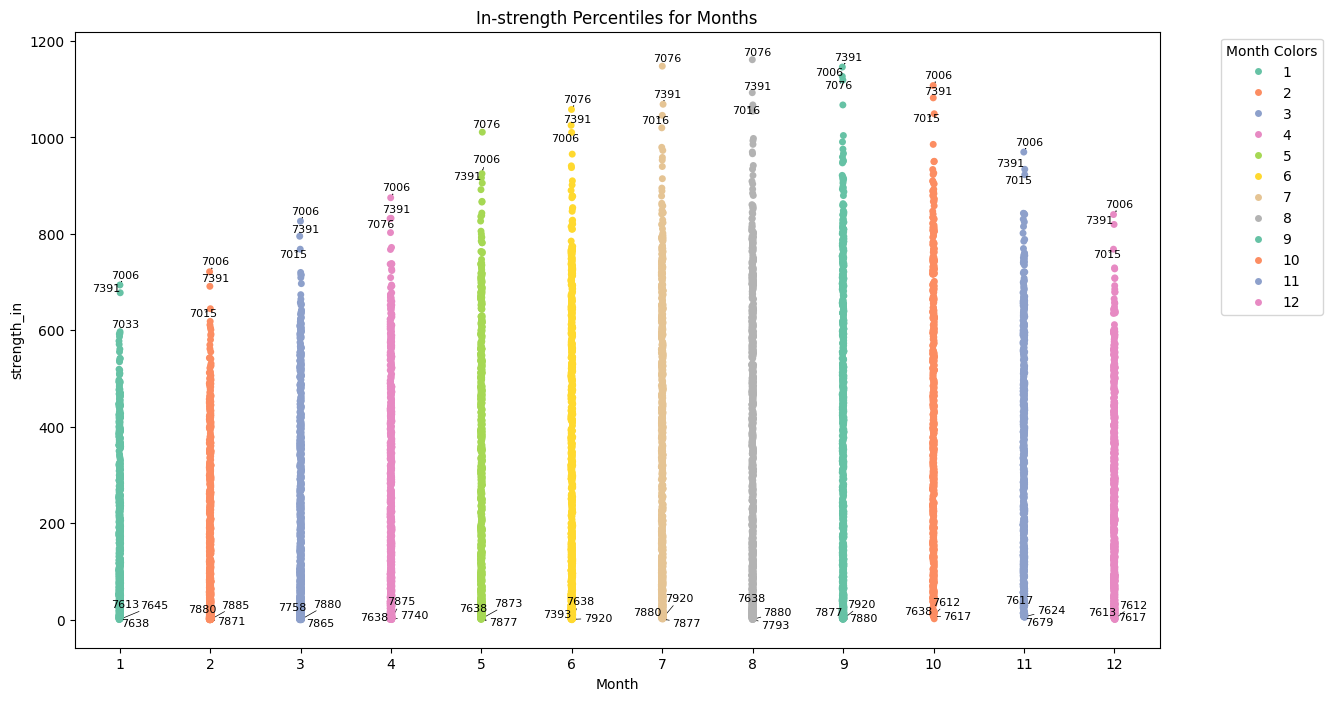

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text

# Plotting
plt.figure(figsize=(14, 8))
sns.stripplot(x="months", y="measure", data=temp_temp_df, jitter=0.01, hue="months", palette="Set2")
plt.title("In-strength Percentiles for Months")
plt.xlabel("Month")
plt.ylabel(f"strength_in")
plt.legend(title="Month Colors", bbox_to_anchor=(1.05, 1), loc='upper left')

# Label top 3–5 highest and lowest per month
texts = []
diff = 1
for month in temp_temp_df['months'].unique():
    month_data = temp_temp_df[temp_temp_df['months'] == month]

    # Sort by measure
    sorted_month = month_data.sort_values('measure')

    # Select lowest 3 and highest 3
    lowest = sorted_month.head(3)
    highest = sorted_month.tail(3)

    outliers = pd.concat([lowest, highest])
    
    for i, row in outliers.iterrows():
        texts.append(plt.text(row['months'] - diff, row['measure'], row['Id'], fontsize=8, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.show()


In [92]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

centralities = ['strength_in', 'strength_out', 'eigenvector_in', 'eigenvector_out', 'betweenness']
nettypes = ['months', 'temp']

for (measure, nettype) in itertools.product(centralities, nettypes):

    temp_df = df.loc[:, pd.IndexSlice[measure, 'years', nettype, :]]
    temp_df.columns = temp_df.columns.droplevel([0,1,2])
    temp_temp_df = temp_df.melt(var_name=nettype, value_name='measure', ignore_index=False).reset_index()
    temp_temp_df = temp_temp_df.dropna(subset=['measure'])

    # Plotting: Strip Plot or Box Plot for months
    plt.figure(figsize=(14, 8))
    sns.stripplot(x=nettype, y="measure", data=temp_temp_df, jitter=0.01, hue=nettype, palette="Set2")
    plt.title(f"{measure} percentiles for {nettype}")
    plt.xlabel(f"{nettype}")
    plt.ylabel(f"{measure}")
    plt.legend(title=f"{nettype} colors", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Label outliers (stations with |z| > 3 for example)
    texts = []
    diff = 0 if nettype == 'temp' else 1
    for group in temp_temp_df[nettype].unique():
        group_data = temp_temp_df[temp_temp_df[nettype] == group]
    
        # Sort by measure
        sorted_group = group_data.sort_values('measure')
    
        # Select lowest 3 and highest 3
        lowest = sorted_group.head(3)
        highest = sorted_group.tail(3)
    
        outliers = pd.concat([lowest, highest])
    
        for i, row in outliers.iterrows():
            texts.append(plt.text(row[nettype] - diff, row['measure'], row['Id'], fontsize=8, ha='center', va='bottom'))

    try:

        text_positions = adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

    except Exception as e:

        print(f"error processing {(measure, nettype)} text adjustment.")
    
    plt.savefig(f'figures/RQ1/measures/{nettype}-{measure}.png', bbox_inches = 'tight')
    plt.close()    
    # plt.show()
    

6 [-0.25478815  0.82506461]
7 [-0.69644356 -0.57268751]
8 [-0.64512707 -0.56287862]
12 [-0.36303921  0.75512844]
13 [-0.49192675 -0.14479756]
19 [-0.10800049 -0.26091809]
20 [-0.66531971  0.76605914]
42 [-0.66284661  0.38837924]
43 [0.75560697 0.10814063]
48 [-0.31518987  0.99047137]
49 [-0.54263861 -0.6684493 ]
0 [-0.51582683 -0.09055124]
1 [0.38436744 0.27972647]
2 [-0.02591053  0.58081353]
6 [ 0.03028588 -0.00048499]
7 [ 0.99756538 -0.88322009]
8 [-0.8710057  -0.43354508]
0 [0.71627405 0.88305366]
1 [-0.83582175  0.84973851]
6 [ 0.9525087  -0.97773523]
7 [-0.09554376 -0.58113119]
8 [-0.94885707 -0.616959  ]
12 [0.75226715 0.58089739]
13 [-0.67835557 -0.8481436 ]
14 [0.69751468 0.57748476]
18 [-0.69485919  0.48794335]
19 [0.74093859 0.76851995]
42 [0.88893598 0.93581392]
43 [-0.23866303 -0.47564256]
0 [0.75229804 0.43191583]
1 [ 0.01733991 -0.38946338]
2 [-0.28063322  0.32851769]
6 [ 0.28430468 -0.45443039]
7 [0.34076493 0.41627858]
8 [-0.37584153 -0.93377488]
12 [-0.15553425 -0.1725

In [105]:
import numpy as np
import glob
import pickle

all_centrality_files = sorted(glob.glob('results/centrality/**/*.pkl', recursive=True))

with open('results/centrality/eigenvector/years/months/network-5.pkl', 'rb') as f:
    temp = pickle.load(f)

y, binedges = np.histogram(temp['nulls']['in']['7000'], bins=20)

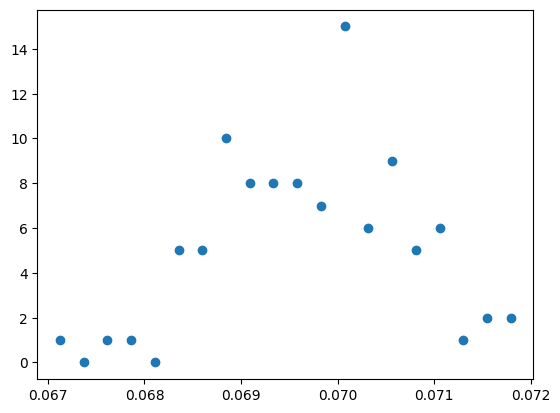

In [106]:
import matplotlib.pyplot as plt

x = (binedges[1:] + binedges[:-1]) / 2
plt.scatter(x, y)

# RQ2.1

In [9]:
df = get_empty_df()

In [11]:
import itertools
import os
import re
from tqdm.notebook import tqdm
import pickle

usertypes = ['members', 'casuals', 'years']
nettypes = ['months', 'temp']
centralities = ['strength', 'eigenvector', 'betweenness']

file_pattern = re.compile('network(?:-temp)?-(\d{1,2})\.pkl')

for folders in tqdm(list(itertools.product(centralities, usertypes, nettypes))):

    centralitytype, usertype, nettype = folders

    folder_path = os.path.join('results','centrality',*folders)

    files = glob.glob(os.path.join(folder_path, '*.pkl'))

    for file in files:
        index_num = int(file_pattern.search(file).group(1))

        with open(file, 'rb') as f:
            result = pickle.load(f)

        if centralitytype == 'betweenness':
            nodes, percentiles = get_betweenness_percentile(result)
            df.loc[nodes, pd.IndexSlice[centralitytype, usertype, nettype, index_num]] = percentiles
        else:
            nodes, percentiles_in, percentiles_out = get_strength_percentile(result)
            df.loc[nodes, pd.IndexSlice[centralitytype + '_in', usertype, nettype, index_num]] = percentiles_in
            df.loc[nodes, pd.IndexSlice[centralitytype + '_out', usertype, nettype, index_num]] = percentiles_out



  0%|          | 0/18 [00:00<?, ?it/s]

In [14]:
temp1 = df.loc[:, pd.IndexSlice['eigenvector_out', 'casuals', 'months', 1]].dropna()
temp1.name = 'casuals'

In [15]:
temp2 = df.loc[:, pd.IndexSlice['eigenvector_out', 'members', 'months', 1]].dropna()
temp2.name = 'members'

In [16]:
temp3 = pd.merge(left=temp1, right=temp2, on='Id')
temp3['diff'] = temp3['members'] - temp3['casuals']

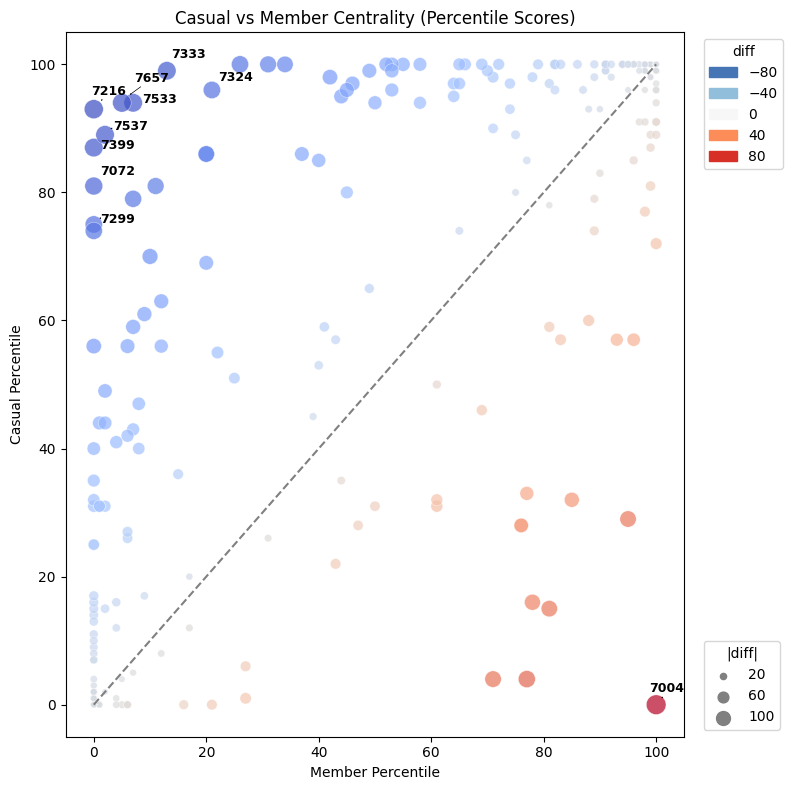

In [514]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from adjustText import adjust_text

plt.figure(figsize=(8,8))
sns.scatterplot(
    data=temp3,
    x='members', 
    y='casuals', 
    hue='diff',
    palette='coolwarm',
    size=abs(temp3['diff']),
    sizes=(20, 200),
    alpha=0.7,
    legend=False # broken
)

# Identity line
plt.plot([0, 100], [0, 100], linestyle='--', color='gray')

# Custom legends

# Color legend
colors = ['#4575b4', '#91bfdb', '#f7f7f7', '#fc8d59', '#d73027']
color_labels = ['−80', '−40', '0', '40', '80']
color_handles = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, color_labels)]

# Size legend
sizes = [20, 60, 100]
size_labels = ['20', '60', '100']
size_handles = [plt.scatter([], [], s=s, color='gray', label=l) for s, l in zip(sizes, size_labels)]

legend1 = plt.legend(handles=color_handles, title="diff", loc='upper left', bbox_to_anchor=(1.02, 1))
legend2 = plt.legend(handles=size_handles, title="|diff|", loc='lower left', bbox_to_anchor=(1.02, 0))

plt.gca().add_artist(legend1)  # Make sure both show up

top_diff = temp3.sort_values('diff',ascending=False,key=abs).head(10)

# Add labels
texts = []
for id, row in top_diff.iterrows():
    texts.append(plt.text(
        row['members'] + 1,
        row['casuals'] + 1,
        id,  # or whatever column stores the station name
        fontsize=9,
        weight='bold'
    ))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.xlabel("Member Percentile")
plt.ylabel("Casual Percentile")
plt.title("Casual vs Member Centrality (Percentile Scores)")
plt.tight_layout()
plt.show()



In [169]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from adjustText import adjust_text

def plot_percentile_comparison(df_compare, measure, filename):

    plt.figure(figsize=(8,8))
    sns.scatterplot(
        data=df_compare,
        x='members', 
        y='casuals', 
        hue='diff',
        palette='coolwarm',
        size=abs(df_compare['diff']),
        sizes=(20, 200),
        alpha=0.7,
        legend=False # broken
    )
    
    # Identity line
    plt.plot([0, 100], [0, 100], linestyle='--', color='gray')
    
    # Custom legends
    
    # Color legend
    colors = ['#4575b4', '#91bfdb', '#f7f7f7', '#fc8d59', '#d73027']
    color_labels = ['−80', '−40', '0', '40', '80']
    color_handles = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, color_labels)]
    
    # Size legend
    sizes = [20, 60, 100]
    size_labels = ['20', '60', '100']
    size_handles = [plt.scatter([], [], s=s, color='gray', label=l) for s, l in zip(sizes, size_labels)]
    
    legend1 = plt.legend(handles=color_handles, title="diff", loc='upper left', bbox_to_anchor=(1.02, 1))
    legend2 = plt.legend(handles=size_handles, title="|diff|", loc='lower left', bbox_to_anchor=(1.02, 0))
    
    plt.gca().add_artist(legend1)  # Make sure both show up
    
    top_diff = df_compare.sort_values('diff',ascending=False,key=abs).head(10)
    
    # Add labels
    texts = []
    for id, row in top_diff.iterrows():
        texts.append(plt.text(
            row['members'] + 1,
            row['casuals'] + 1,
            id,  # or whatever column stores the station name
            fontsize=9,
            weight='bold'
        ))
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))
    
    plt.xlabel("Member Percentile")
    plt.ylabel("Casual Percentile")
    plt.title(f"Percentile Scores - {measure}")
    plt.tight_layout()
    plt.savefig(filename, bbox_inches = 'tight')
    plt.close() 
    


In [172]:
import itertools
import os

measures = ['betweenness', 'eigenvector_in', 'eigenvector_out']
nettypes = ['months', 'temp']
temp_range = range(6)
month_range = range(1,13)

for (measure, nettype) in itertools.product(measures,nettypes):

    r = month_range if nettype == 'months' else temp_range

    for i in r:

        casuals_s = df.loc[:, pd.IndexSlice[measure, 'casuals', nettype, i]].dropna()
        casuals_s.name = 'casuals'

        members_s = df.loc[:, pd.IndexSlice[measure, 'members', nettype, i]].dropna()
        members_s.name = 'members'

        combined_df = pd.merge(left=casuals_s, right=members_s, on='Id')
        combined_df['diff'] = combined_df['members'] - combined_df['casuals']

        filename = os.path.join('figures', 'RQ2.1', measure, nettype, f'usercomp-{i}-percentiles.png')

        plot_percentile_comparison(combined_df, measure, filename)

0 [-0.96692727  0.60680306]
1 [ 0.74983977 -0.56515408]
0 [-0.37941681 -0.05276525]
1 [ 0.87979438 -0.75274526]
6 [ 0.83274995 -0.53583153]
7 [0.2005056  0.82149092]
0 [-0.77990862  0.45054378]
1 [ 0.16982664 -0.15479633]
6 [-0.3965744   0.82604844]
7 [0.26491952 0.23033891]
0 [0.57977064 0.2725995 ]
2 [0.58629517 0.50028962]
0 [ 0.61921916 -0.62954249]
1 [-0.86141625  0.0098065 ]


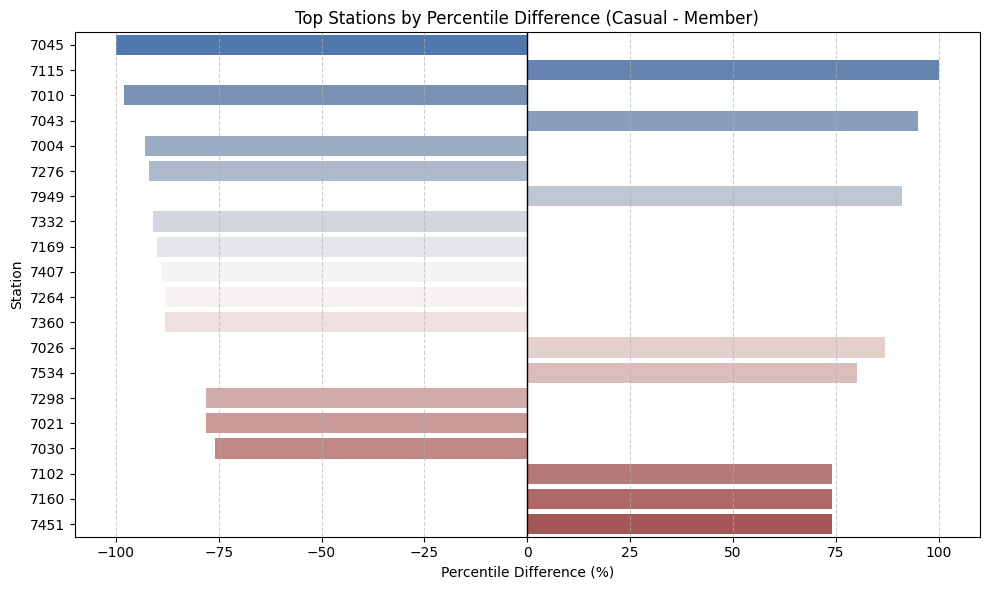

In [153]:
# Select top stations by absolute percentile difference
top_diff = temp3.reindex(temp3['diff'].abs().sort_values(ascending=False).head(20).index)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_diff,
    y='Id',
    x='diff',
    palette='vlag',
    hue='Id',
    legend=False
)
plt.axvline(0, color='black', linewidth=1)
plt.title('Top Stations by Percentile Difference (Casual - Member)')
plt.xlabel('Percentile Difference (%)')
plt.ylabel('Station')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# RQ2.2 

In [461]:
import pandas as pd

df = pd.read_csv('grouped_stations.csv', index_col=0).sort_values('Id').reset_index(drop=True)
df['Id'] = df['Id'].astype(str)

In [200]:
import networkx as nx
import os

nettype = 'months'
ind = 1

casuals_net_file = f"../networks/casuals/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
G_casuals = nx.read_gml(casuals_net_file)

members_net_file = f"../networks/members/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
G_members = nx.read_gml(members_net_file)

In [214]:
all_stations = set(G_casuals.nodes()).union(set(G_members))

# G_casuals_common = nx.subgraph(G_casuals, common_stations)
# G_members_common = nx.subgraph(G_members, common_stations)

In [232]:
members_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_members.edges(data=True)])
casuals_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_casuals.edges(data=True)])

In [241]:
keys = set(members_edges_dict) | set(casuals_edges_dict)
result = {k: members_edges_dict.get(k, 0) - casuals_edges_dict.get(k, 0) for k in keys}

In [243]:
result_edges = [(node[0], node[1], {'tpd_diff': value}) for node, value in result.items()]

In [245]:
G_diff = nx.DiGraph()
G_diff.add_edges_from(result_edges)

In [269]:
# add coordinates
nodelist = list(G_diff.nodes())

data = dict([(str(x[0]), {'Latitude': x[1], 'Longitude': x[2], 'Name': x[3]}) for x in list(zip(df['Id'], df['lat'], df['lng'], df['Name'])) if x[0] in nodelist])

nx.set_node_attributes(G_diff, data)


In [272]:
from tqdm.notebook import tqdm

nettype = 'months'

for ind in tqdm(range(1, 13)):
    
    casuals_net_file = f"../networks/casuals/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
    G_casuals = nx.read_gml(casuals_net_file)
    
    members_net_file = f"../networks/members/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
    G_members = nx.read_gml(members_net_file)

    members_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_members.edges(data=True)])
    casuals_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_casuals.edges(data=True)])

    keys = set(members_edges_dict) | set(casuals_edges_dict)
    result = {k: members_edges_dict.get(k, 0) - casuals_edges_dict.get(k, 0) for k in keys}

    result_edges = [(node[0], node[1], {'tpd_diff': value}) for node, value in result.items()]

    G_diff = nx.DiGraph()
    G_diff.add_edges_from(result_edges)

    nodelist = list(G_diff.nodes())

    data = dict([(str(x[0]), {'Latitude': x[1], 'Longitude': x[2], 'Name': x[3]}) for x in list(zip(df['Id'], df['lat'], df['lng'], df['Name'])) if x[0] in nodelist])
    
    nx.set_node_attributes(G_diff, data)

    nx.write_gml(G_diff, f'../networks/diff/{nettype}/diff-network-{ind}.gml')

  0%|          | 0/12 [00:00<?, ?it/s]

In [273]:
nettype = 'temp'

for ind in tqdm(range(6)):
    casuals_net_file = f"../networks/casuals/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
    G_casuals = nx.read_gml(casuals_net_file)
    
    members_net_file = f"../networks/members/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
    G_members = nx.read_gml(members_net_file)

    members_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_members.edges(data=True)])
    casuals_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_casuals.edges(data=True)])

    keys = set(members_edges_dict) | set(casuals_edges_dict)
    result = {k: members_edges_dict.get(k, 0) - casuals_edges_dict.get(k, 0) for k in keys}

    result_edges = [(node[0], node[1], {'tpd_diff': value}) for node, value in result.items()]

    G_diff = nx.DiGraph()
    G_diff.add_edges_from(result_edges)

    nodelist = list(G_diff.nodes())

    data = dict([(str(x[0]), {'Latitude': x[1], 'Longitude': x[2], 'Name': x[3]}) for x in list(zip(df['Id'], df['lat'], df['lng'], df['Name'])) if x[0] in nodelist])
    
    nx.set_node_attributes(G_diff, data)

    nx.write_gml(G_diff, f'../networks/diff/{nettype}/diff-network-{ind}.gml')

  0%|          | 0/6 [00:00<?, ?it/s]

# RQ2.2.5

In [12]:
import pandas as pd

stations_df = pd.read_csv('grouped_stations.csv', index_col=0).sort_values('Id').reset_index(drop=True)
stations_df['Id'] = stations_df['Id'].astype(str)

In [527]:
import networkx as nx
import os

nettype = 'temp'
ind = 1

casuals_net_file = f"../networks/casuals/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
G_casuals = nx.read_gml(casuals_net_file)

members_net_file = f"../networks/members/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
G_members = nx.read_gml(members_net_file)

In [528]:
all_stations = set(G_casuals.nodes()).intersection(set(G_members))

G_casuals_common = nx.subgraph(G_casuals, all_stations)
G_members_common = nx.subgraph(G_members, all_stations)

In [529]:
members_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_members_common.edges(data=True)])
casuals_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_casuals_common.edges(data=True)])

In [530]:
keys = set(members_edges_dict) | set(casuals_edges_dict)
result = {k: (members_edges_dict.get(k, 0) + casuals_edges_dict.get(k, 0)) / 2 for k in keys}

In [531]:
result_edges = [(node[0], node[1], {'tpd_avg': value}) for node, value in result.items()]

In [532]:
G_diff = nx.DiGraph()
G_diff.add_edges_from(result_edges)

In [534]:
# add coordinates
nodelist = list(G_diff.nodes())

data = dict([(str(x[0]), {'Latitude': x[1], 'Longitude': x[2], 'Name': x[3]}) for x in list(zip(stations_df['Id'], stations_df['lat'], stations_df['lng'], stations_df['Name'])) if x[0] in nodelist])

nx.set_node_attributes(G_diff, data)


In [18]:
centrality_df = df.copy()

In [19]:
temp1 = centrality_df.loc[:, pd.IndexSlice['eigenvector_out', 'casuals', nettype, ind]].dropna()
temp1.name = 'casuals'

temp2 = centrality_df.loc[:, pd.IndexSlice['eigenvector_out', 'members', nettype, ind]].dropna()
temp2.name = 'members'

temp3 = pd.merge(left=temp1, right=temp2, on='Id')
temp3['diff'] = temp3['members'] - temp3['casuals']

In [539]:
# betweenness_diff = temp3
betweenness_data = {k: {'Betweenness': v} for k,v in betweenness_diff['diff'].to_dict().items()}
nx.set_node_attributes(G_diff, betweenness_data)

In [542]:
# eigenvector_in_diff = temp3
eigenvector_in_data = {k: {'In_Eigenvector': v} for k,v in eigenvector_in_diff['diff'].to_dict().items()}
nx.set_node_attributes(G_diff, eigenvector_in_data)

In [545]:
# eigenvector_out_diff = temp3
eigenvector_out_data = {k: {'Out_Eigenvector': v} for k,v in eigenvector_out_diff['diff'].to_dict().items()}
nx.set_node_attributes(G_diff, eigenvector_out_data)

In [548]:
nx.write_gml(G_diff, f'../networks/diff/temp/centdiff-network-1.gml')

In [22]:
from tqdm.notebook import tqdm

centrality_df = df.copy()

nettype = 'months'

for ind in tqdm(range(1, 13)):
    
    casuals_net_file = f"../networks/casuals/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
    G_casuals = nx.read_gml(casuals_net_file)
    
    members_net_file = f"../networks/members/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
    G_members = nx.read_gml(members_net_file)

    all_stations = set(G_casuals.nodes()).intersection(set(G_members))

    G_casuals_common = nx.subgraph(G_casuals, all_stations)
    G_members_common = nx.subgraph(G_members, all_stations)

    members_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_members_common.edges(data=True)])
    casuals_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_casuals_common.edges(data=True)])

    keys = set(members_edges_dict) | set(casuals_edges_dict)
    result = {k: (members_edges_dict.get(k, 0) + casuals_edges_dict.get(k, 0)) / 2 for k in keys}

    result_edges = [(node[0], node[1], {'tpd_diff': value}) for node, value in result.items()]

    G_diff = nx.DiGraph()
    G_diff.add_edges_from(result_edges)

    nodelist = list(G_diff.nodes())

    data = dict([(str(x[0]), {'Latitude': x[1], 'Longitude': x[2], 'Name': x[3]}) for x in list(zip(stations_df['Id'], stations_df['lat'], stations_df['lng'], stations_df['Name'])) if x[0] in nodelist])
    
    nx.set_node_attributes(G_diff, data)

    for centrality in ['betweenness', 'eigenvector_in', 'eigenvector_out']:
        
        temp1 = centrality_df.loc[:, pd.IndexSlice[centrality, 'casuals', nettype, ind]].dropna()
        temp1.name = 'casuals'
        
        temp2 = centrality_df.loc[:, pd.IndexSlice[centrality, 'members', nettype, ind]].dropna()
        temp2.name = 'members'
        
        temp3 = pd.merge(left=temp1, right=temp2, on='Id')
        temp3['diff'] = temp3['members'] - temp3['casuals']

        centrality_data = {k: {centrality.capitalize(): v} for k,v in temp3['diff'].to_dict().items()}
        nx.set_node_attributes(G_diff, centrality_data)

    nx.write_gml(G_diff, f'../networks/diff/{nettype}/centdiff-network-{ind}.gml')

  0%|          | 0/12 [00:00<?, ?it/s]

In [23]:
from tqdm.notebook import tqdm

centrality_df = df.copy()

nettype = 'temp'

for ind in tqdm(range(6)):
    
    casuals_net_file = f"../networks/casuals/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
    G_casuals = nx.read_gml(casuals_net_file)
    
    members_net_file = f"../networks/members/average/{nettype}/network-{'' if nettype == 'months' else 'temp-'}{ind}.gml"
    G_members = nx.read_gml(members_net_file)

    all_stations = set(G_casuals.nodes()).intersection(set(G_members))

    G_casuals_common = nx.subgraph(G_casuals, all_stations)
    G_members_common = nx.subgraph(G_members, all_stations)

    members_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_members_common.edges(data=True)])
    casuals_edges_dict = dict([((x[0], x[1]), x[2]['tpd_weights']) for x in G_casuals_common.edges(data=True)])

    keys = set(members_edges_dict) | set(casuals_edges_dict)
    result = {k: (members_edges_dict.get(k, 0) + casuals_edges_dict.get(k, 0)) / 2 for k in keys}

    result_edges = [(node[0], node[1], {'tpd_diff': value}) for node, value in result.items()]

    G_diff = nx.DiGraph()
    G_diff.add_edges_from(result_edges)

    nodelist = list(G_diff.nodes())

    data = dict([(str(x[0]), {'Latitude': x[1], 'Longitude': x[2], 'Name': x[3]}) for x in list(zip(stations_df['Id'], stations_df['lat'], stations_df['lng'], stations_df['Name'])) if x[0] in nodelist])
    
    nx.set_node_attributes(G_diff, data)

    for centrality in ['betweenness', 'eigenvector_in', 'eigenvector_out']:
        
        temp1 = centrality_df.loc[:, pd.IndexSlice[centrality, 'casuals', nettype, ind]].dropna()
        temp1.name = 'casuals'
        
        temp2 = centrality_df.loc[:, pd.IndexSlice[centrality, 'members', nettype, ind]].dropna()
        temp2.name = 'members'
        
        temp3 = pd.merge(left=temp1, right=temp2, on='Id')
        temp3['diff'] = temp3['members'] - temp3['casuals']

        centrality_data = {k: {centrality.capitalize(): v} for k,v in temp3['diff'].to_dict().items()}
        nx.set_node_attributes(G_diff, centrality_data)

    nx.write_gml(G_diff, f'../networks/diff/{nettype}/centdiff-network-{ind}.gml')

  0%|          | 0/6 [00:00<?, ?it/s]

# RQ2.3

In [351]:
import pandas as pd
import numpy as np

def get_empty_efficiency_df(length):

    columns = ['global_efficiency', 'ge_percentile', 'ge_zscore', 'ge_ratio', 'nulls_mu', 'nulls_sigma', 'usertype', 'nettype', 'index']
    
    # Create dummy data
    df = pd.DataFrame(index=range(length), columns=columns)
    df = df.sort_index(axis=1)

    return df

In [293]:
efficiency_files = sorted(glob.glob('results/efficiency/**/*.pkl', recursive=True))

In [306]:
import numpy as np
from scipy.stats import percentileofscore

def get_percentile(x, nulls):

    return percentileofscore(nulls, x, kind='rank')

In [335]:
def get_z_score_extra(x, nulls):

    # Mean and std of null model measurements
    mu = np.mean(nulls)
    sigma = np.std(nulls, ddof=1)  # ddof=1 for sample standard deviation

    if sigma == 0:
        if x == mu:
            return 0 
        else:
            return np.inf * np.sign(x - mu) 
    
    # Compute z-score
    z_score = (x - mu) / sigma

    return z_score, mu, sigma

In [325]:
def get_ratio(x, nulls):
    mu = np.mean(nulls)
    return x / mu

## over time

In [289]:
from tqdm.notebook import tqdm
import pickle
import pandas as pd
import glob
from collections import defaultdict

In [366]:
results_df = get_empty_efficiency_df(len(efficiency_files))

In [374]:
import itertools
import os
import re
from tqdm.notebook import tqdm

usertypes = ['members', 'casuals', 'years']
nettypes = ['months', 'temp']

file_pattern = re.compile('network(?:-temp)?-(\d{1,2})\.pkl')

file_num = 0

for folders in tqdm(list(itertools.product(usertypes, nettypes))):

    usertype, nettype = folders

    folder_path = os.path.join('results','efficiency', 'global' ,*folders)

    files = glob.glob(os.path.join(folder_path, '*.pkl'))

    for file in files:
        
        index_num = int(file_pattern.search(file).group(1))

        with open(file, 'rb') as f:
            result = pickle.load(f)

        efficiency_obs, efficiency_null = result['orig'], result['nulls']

        efficiency_percentile = get_percentile(efficiency_obs, efficiency_null)

        efficiency_zscore, nulls_mu, nulls_sigma = get_z_score_extra(efficiency_obs, efficiency_null)

        efficiency_ratio = get_ratio(efficiency_obs, efficiency_null)

        results_df.loc[file_num, ['global_efficiency', 'ge_percentile', 'ge_zscore', 'ge_ratio', 'nulls_mu', 'nulls_sigma', 'usertype', 'nettype', 'index']] = \
            [efficiency_obs, efficiency_percentile, efficiency_zscore, efficiency_ratio, nulls_mu, nulls_sigma, usertype, nettype, index_num]

        file_num += 1

results_df = results_df.astype({'index': int, 'global_efficiency': float, 'ge_percentile': int, 'ge_zscore': float, 'nulls_mu': float, 'nulls_sigma': float})

        

  0%|          | 0/6 [00:00<?, ?it/s]

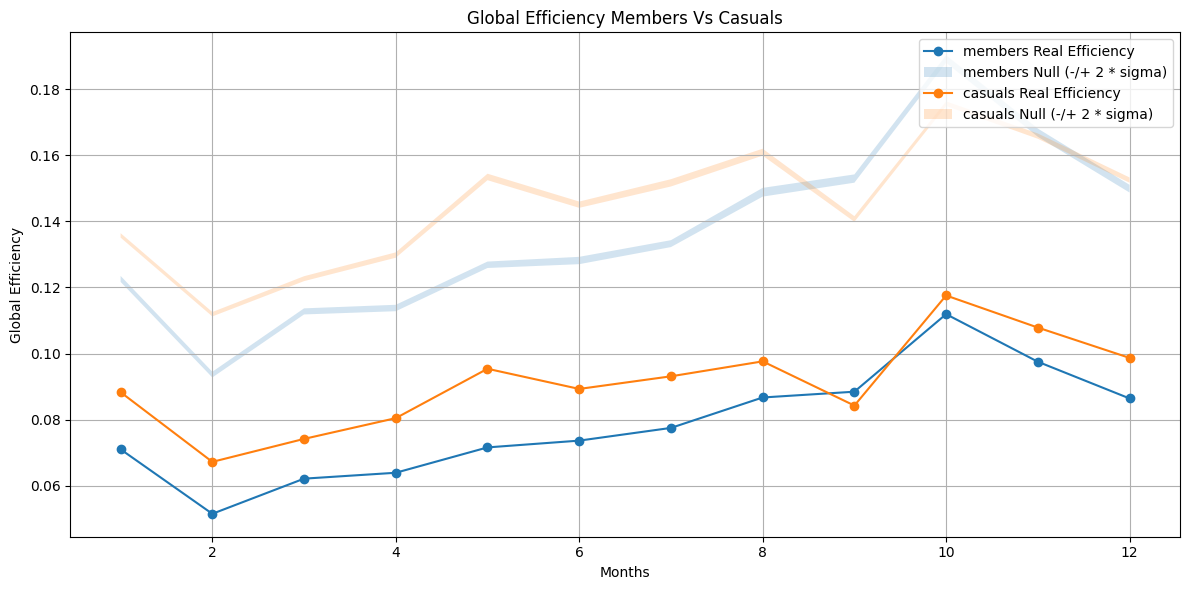

In [383]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

usertypes = ['members', 'casuals']
nettypes = ['months', 'temp']

nettype = 'months'

for user in usertypes:
    df = results_df[(results_df['usertype'] == user) & (results_df['nettype'] == nettype)].sort_values('index')
    
    plt.plot(df['index'], df['global_efficiency'], label=f'{user} Real Efficiency', marker='o')
    
    # Add confidence interval from null models
    plt.fill_between(df['index'],
                     df['nulls_mu'] - 2*df['nulls_sigma'],
                     df['nulls_mu'] + 2*df['nulls_sigma'],
                     alpha=0.2, label=f'{user} Null (-/+ 2 * sigma)')

plt.xlabel(f'{nettype}'.capitalize())
plt.ylabel('Global Efficiency')
plt.title('Global Efficiency Members Vs Casuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/RQ2.3/usercompar-efficiency-months.png', bbox_inches = 'tight')
plt.show()


## over temperature

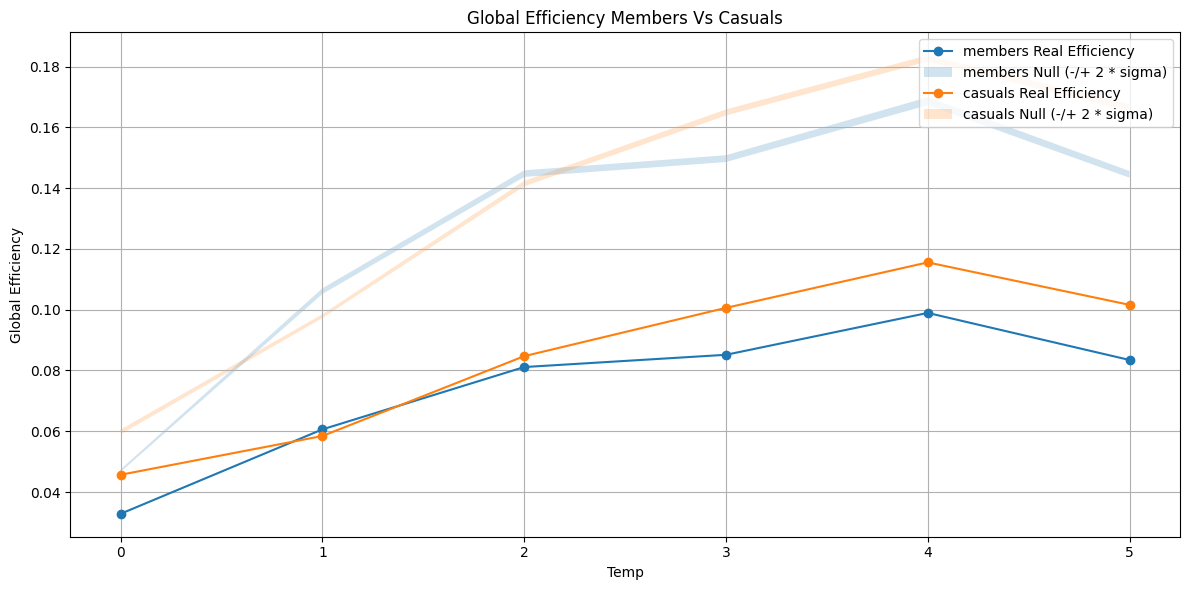

In [384]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

usertypes = ['members', 'casuals']
nettypes = ['months', 'temp']

nettype = 'temp'

for user in usertypes:
    df = results_df[(results_df['usertype'] == user) & (results_df['nettype'] == nettype)].sort_values('index')
    
    plt.plot(df['index'], df['global_efficiency'], label=f'{user} Real Efficiency', marker='o')
    
    # Add confidence interval from null models
    plt.fill_between(df['index'],
                     df['nulls_mu'] - 2*df['nulls_sigma'],
                     df['nulls_mu'] + 2*df['nulls_sigma'],
                     alpha=0.2, label=f'{user} Null (-/+ 2 * sigma)')

plt.xlabel(f'{nettype}'.capitalize())
plt.ylabel('Global Efficiency')
plt.title('Global Efficiency Members Vs Casuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/RQ2.3/usercompar-efficiency-temps.png', bbox_inches = 'tight')
plt.show()


# RQ3

In [5]:
## find the stations

In [127]:
def get_mod_zscore(x, nulls):

    # Mean and std of null model measurements
    mu = np.mean(nulls)
    sigma = np.std(nulls ,ddof = 1)
    eps = 1e-6

    zscore = (x - mu) / (mu + eps)

    # return zscore, mu, sigma
    return zscore

In [128]:
def get_betweenness_mod_zscores(result):
    
    nodes = list(result['orig'].keys())

    obs_values, null_values = zip(*[(result['orig'][node], result['nulls'][node]) for node in nodes])

    mod_zscores = list(map(get_mod_zscore, obs_values, null_values))

    return nodes, mod_zscores

    # mod_zscores, mod_mus, mod_sigmas = zip(*list(map(get_mod_zscore, obs_values, null_values)))

    # return nodes, mod_zscores, mod_mus, mod_sigmas

def get_strength_mod_zscores(result):
    
    nodes = list(result['orig']['in'].keys())

    # in calculation

    obs_values_in, null_values_in = zip(*[(result['orig']['in'][node], result['nulls']['in'][node]) for node in nodes])

    mod_zscores_in = list(map(get_mod_zscore, obs_values_in, null_values_in))
    
    # mod_zscores_in, mod_mus_in, mod_sigmas_in = zip(*list(map(get_mod_zscore, obs_values_in, null_values_in)))

    # out calculation

    obs_values_out, null_values_out = zip(*[(result['orig']['out'][node], result['nulls']['out'][node]) for node in nodes])

    mod_zscores_out = list(map(get_mod_zscore, obs_values_out, null_values_out))
    
    # mod_zscores_out, mod_mus_out, mod_sigmas_out = zip(*list(map(get_mod_zscore, obs_values_out, null_values_out)))

    return nodes, mod_zscores_in, mod_zscores_out
    # return nodes, mod_zscores_in, mod_zscores_out, mod_mus_in, mod_mus_out, mod_sigmas_in, mod_sigmas_out

In [129]:
df = get_empty_df()
# df_mu = get_empty_df()
# df_sigma = get_empty_df()

In [130]:
import itertools
import os
import re
from tqdm.notebook import tqdm
import pickle
import glob

usertypes = ['members', 'casuals', 'years']
nettypes = ['months', 'temp']
centralities = ['strength', 'eigenvector', 'betweenness']

file_pattern = re.compile('network(?:-temp)?-(\d{1,2})\.pkl')

for folders in tqdm(list(itertools.product(centralities, usertypes, nettypes))):

    centralitytype, usertype, nettype = folders

    folder_path = os.path.join('results','centrality',*folders)

    files = glob.glob(os.path.join(folder_path, '*.pkl'))

    for file in files:
        index_num = int(file_pattern.search(file).group(1))

        with open(file, 'rb') as f:
            result = pickle.load(f)

        if centralitytype == 'betweenness':
            # nodes, mod_zscores, mod_mus, mod_sigmas = get_betweenness_mod_zscores(result)
            nodes, mod_zscores = get_betweenness_mod_zscores(result)
            df.loc[nodes, pd.IndexSlice[centralitytype, usertype, nettype, index_num]] = mod_zscores
            # df_mu.loc[nodes, pd.IndexSlice[centralitytype, usertype, nettype, index_num]] = mod_mus
            # df_sigma.loc[nodes, pd.IndexSlice[centralitytype, usertype, nettype, index_num]] = mod_sigmas
        else:
            # nodes, mod_zscores_in, mod_zscores_out, mod_mus_in, mod_mus_out, mod_sigmas_in, mod_sigmas_out = \
            #     get_strength_mod_zscores(result)
            nodes, mod_zscores_in, mod_zscores_out = get_strength_mod_zscores(result)
            df.loc[nodes, pd.IndexSlice[centralitytype + '_in', usertype, nettype, index_num]] = mod_zscores_in
            df.loc[nodes, pd.IndexSlice[centralitytype + '_out', usertype, nettype, index_num]] = mod_zscores_out
            # df_mu.loc[nodes, pd.IndexSlice[centralitytype + '_in', usertype, nettype, index_num]] = mod_mus_in
            # df_mu.loc[nodes, pd.IndexSlice[centralitytype + '_out', usertype, nettype, index_num]] = mod_mus_out
            # df_sigma.loc[nodes, pd.IndexSlice[centralitytype + '_in', usertype, nettype, index_num]] = mod_sigmas_in
            # df_sigma.loc[nodes, pd.IndexSlice[centralitytype + '_out', usertype, nettype, index_num]] = mod_sigmas_out



  0%|          | 0/18 [00:00<?, ?it/s]

In [131]:
centrality = 'eigenvector_in'
nettype = 'months'

df_casuals = df.loc[:, pd.IndexSlice[centrality, 'casuals', nettype, :]]
df_casuals.columns = df_casuals.columns.droplevel([0,1,2])
df_members = df.loc[:, pd.IndexSlice[centrality, 'members', nettype, :]]
df_members.columns = df_members.columns.droplevel([0,1,2])

In [132]:
df_casuals['forget'] = df_casuals.apply(lambda x: np.any(x.loc[:].abs() < 0.01), axis=1)
df_members['forget'] = df_members.apply(lambda x: np.any(x.loc[:].abs() < 0.01), axis=1)

/tmp/ipykernel_12473/1049472295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_casuals['forget'] = df_casuals.apply(lambda x: np.any(x.loc[:].abs() < 0.01), axis=1)
/tmp/ipykernel_12473/1049472295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_members['forget'] = df_members.apply(lambda x: np.any(x.loc[:].abs() < 0.01), axis=1)


In [133]:
casuals_most_varying = set(df_casuals[df_casuals['forget'] != True].dropna(axis=0).std(axis=1, ddof=1).astype(float).nlargest(5).index)
members_most_varying = set(df_members[df_casuals['forget'] != True].dropna(axis=0).std(axis=1, ddof=1).astype(float).nlargest(5).index)

In [134]:
all_varying_stations = casuals_most_varying.union(members_most_varying)

In [143]:
station = '7171'

temp_casuals = df_casuals.loc[station]
temp_casuals = temp_casuals[temp_casuals.index != 'forget']
temp_casuals.name = 'casuals'

temp_members = df_members.loc[station]
temp_members = temp_members[temp_members.index != 'forget']
temp_members.name = 'members'

temp_df = pd.concat([temp_members, temp_casuals], axis=1)

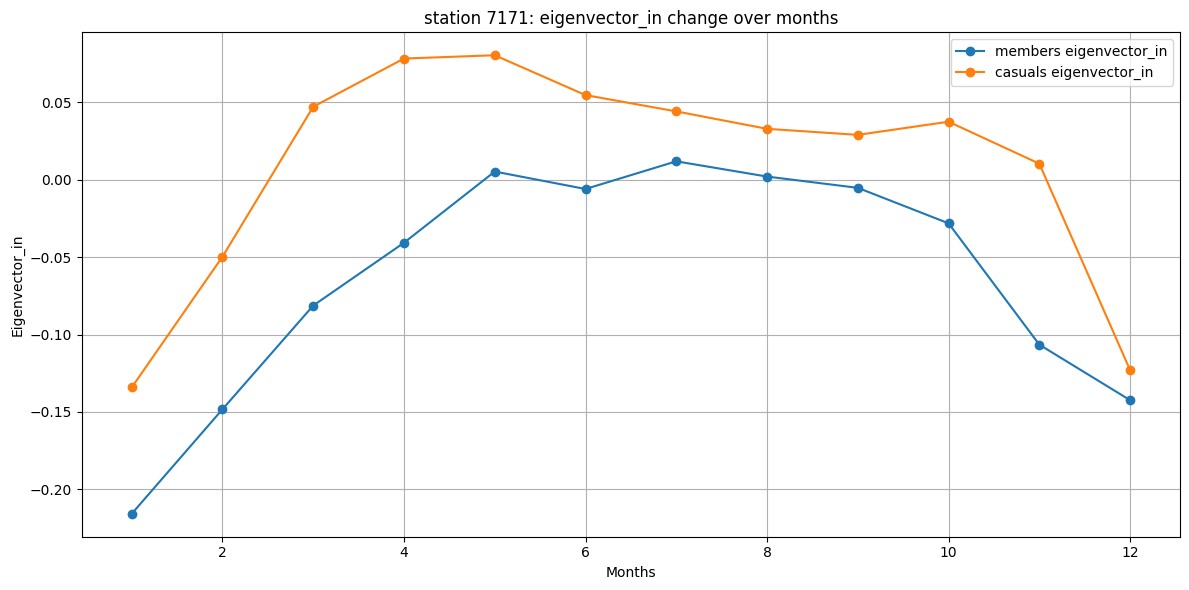

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

usertypes = ['members', 'casuals']
nettypes = ['months', 'temp']

nettype = 'months'

for user in usertypes:
    # df = results_df[(results_df['usertype'] == user) & (results_df['nettype'] == nettype)].sort_values('index')
    plt.plot(temp_df.index, temp_df[user], label=f'{user} {centrality}', marker='o')
    

plt.xlabel(f'{nettype}'.capitalize())
plt.ylabel(f'{centrality}'.capitalize())
plt.title(f'station {station}: {centrality} change over {nettype}')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('figures/RQ2.3/usercompar-efficiency-months.png', bbox_inches = 'tight')
plt.show()


In [148]:
import itertools
import matplotlib.pyplot as plt


centralities = ['betweenness', 'eigenvector_in', 'eigenvector_out']
nettypes = ['months', 'temp']
usertypes = ['casuals', 'members']

for centrality, nettype in itertools.product(centralities, nettypes):

    df_casuals = df.loc[:, pd.IndexSlice[centrality, 'casuals', nettype, :]]
    df_casuals.columns = df_casuals.columns.droplevel([0,1,2])
    df_members = df.loc[:, pd.IndexSlice[centrality, 'members', nettype, :]]
    df_members.columns = df_members.columns.droplevel([0,1,2])

    df_casuals['forget'] = df_casuals.apply(lambda x: np.any(x.loc[:].abs() < 0.01), axis=1)
    df_members['forget'] = df_members.apply(lambda x: np.any(x.loc[:].abs() < 0.01), axis=1)

    casuals_most_varying = set(df_casuals[df_casuals['forget'] != True].dropna(axis=0).std(axis=1, ddof=1).astype(float).nlargest(5).index)
    members_most_varying = set(df_members[df_casuals['forget'] != True].dropna(axis=0).std(axis=1, ddof=1).astype(float).nlargest(5).index)

    all_varying_stations = casuals_most_varying.union(members_most_varying)

    for station in all_varying_stations:

        temp_casuals = df_casuals.loc[station]
        temp_casuals = temp_casuals[temp_casuals.index != 'forget']
        temp_casuals.name = 'casuals'
        
        temp_members = df_members.loc[station]
        temp_members = temp_members[temp_members.index != 'forget']
        temp_members.name = 'members'
        
        temp_df = pd.concat([temp_members, temp_casuals], axis=1)

        plt.figure(figsize=(12,6))

        for user in usertypes:
            # df = results_df[(results_df['usertype'] == user) & (results_df['nettype'] == nettype)].sort_values('index')
            plt.plot(temp_df.index, temp_df[user], label=f'{user} {centrality}', marker='o')
        
        plt.xlabel(f'{nettype}'.capitalize())
        plt.ylabel(f'{centrality}'.capitalize())
        plt.title(f'station {station}: {centrality} change over {nettype}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'figures/RQ3/{centrality}/{nettype}/station-{station}.png', bbox_inches = 'tight')
        # plt.show()
        plt.close()

/tmp/ipykernel_12473/3850273431.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_casuals['forget'] = df_casuals.apply(lambda x: np.any(x.loc[:].abs() < 0.01), axis=1)
/tmp/ipykernel_12473/3850273431.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_members['forget'] = df_members.apply(lambda x: np.any(x.loc[:].abs() < 0.01), axis=1)
/tmp/ipykernel_12473/3850273431.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

# Motifs - RQ1

In [237]:
import pandas as pd
import numpy as np

def get_empty_motifs_df():

    # Define your structure
    usertypes = ['members', 'casuals', 'years']
    nettypes = ['months', 'temp']
    month_ids = list(range(1, 13))      
    temperature_ids = list(range(6)) 
    
    # Build the column MultiIndex
    cols = []
    
    for u in usertypes:
        for i in month_ids:
            cols.append((u, 'months', i))
        for i in temperature_ids:
            cols.append((u, 'temp', i))
    
    # Create the MultiIndex
    multi_index = pd.MultiIndex.from_tuples(cols, names=['usertype', 'nettype', 'index'])
    
    # Create dummy data
    df = pd.DataFrame(index=pd.Index(range(1, 14), name='motif'), columns=multi_index)
    df = df.sort_index(axis=1)

    return df

In [238]:
import numpy as np
from scipy.stats import percentileofscore

def get_percentile(x, nulls):

    return percentileofscore(nulls, x, kind='rank')

def get_mod_zscore(x, nulls):

    # Mean and std of null model measurements
    mu = np.mean(nulls)
    sigma = np.std(nulls ,ddof = 1)
    eps = 1e-6

    zscore = (x - mu) / (mu + eps)

    # return zscore, mu, sigma
    return zscore

In [239]:
def get_motifs_measures(result):

    motifs = np.vstack(list(result['orig']['I'].values()))

    motifs_sum = motifs.sum(axis=0)

    nulls_motifs = np.stack(list(result['nulls']['I'].values()), axis=0)

    nulls_motifs_sum = nulls_motifs.sum(axis=0)

    percentiles = np.array([get_percentile(motif_x, motif_nulls) for (motif_x, motif_nulls) in zip(motifs_sum, nulls_motifs_sum)])

    z_scores = np.array([get_mod_zscore(motif_x, motif_nulls) for (motif_x, motif_nulls) in zip(motifs_sum, nulls_motifs_sum)])

    return motifs_sum, percentiles, z_scores

In [240]:
df_orig = get_empty_motifs_df()
df_zscore = get_empty_motifs_df()
df_percentile = get_empty_motifs_df()

In [241]:
import itertools
import os
import re
from tqdm.notebook import tqdm
import pickle
import glob

usertypes = ['members', 'casuals', 'years']
nettypes = ['months', 'temp']

file_pattern = re.compile('network(?:-temp)?-(\d{1,2})\.pkl')

for folders in tqdm(list(itertools.product(usertypes, nettypes))):

    usertype, nettype = folders

    folder_path = os.path.join('results','motifs',*folders)

    files = glob.glob(os.path.join(folder_path, '*.pkl'))

    for file in files:
        index_num = int(file_pattern.search(file).group(1))

        with open(file, 'rb') as f:
            result = pickle.load(f)

        motifs, percentiles, z_scores = get_motifs_measures(result)
        
        df_orig.loc[:, pd.IndexSlice[usertype, nettype, index_num]] = motifs
        df_percentile.loc[:, pd.IndexSlice[usertype, nettype, index_num]] = percentiles
        df_zscore.loc[:, pd.IndexSlice[usertype, nettype, index_num]] = z_scores



  0%|          | 0/6 [00:00<?, ?it/s]

In [304]:
temp_df = df_orig.loc[:, pd.IndexSlice['years', nettype, :]]
temp_df.columns = temp_df.columns.droplevel([0,1])
temp_temp_df = temp_df.melt(var_name=nettype, value_name='intensity', ignore_index=False).reset_index()
temp_temp_df['intensity'] = temp_temp_df['intensity'].astype(float)

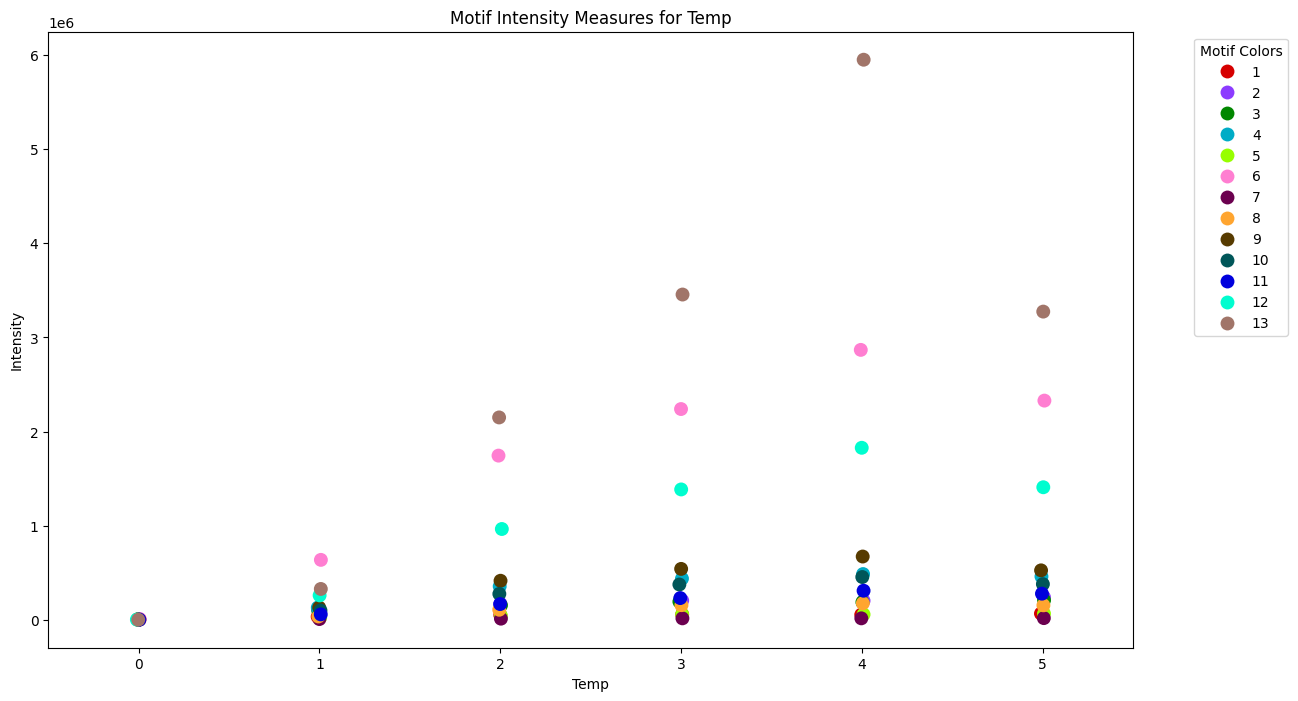

In [305]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
import colorcet as cc

# Plotting: Strip Plot or Box Plot for months
plt.figure(figsize=(14, 8))
color_palette = sns.color_palette(cc.glasbey, n_colors=temp_temp_df['motif'].nunique())
sns.stripplot(x=nettype, y="intensity", data=temp_temp_df, jitter=0.01, hue="motif", palette=color_palette, size=10)
# plt.axhline(y=99, color='red', linestyle='--', label="min(percentile, 100 - percentile) < 1")
# plt.axhline(y=1, color='red', linestyle='--')
plt.title(f"Motif Intensity Measures for {nettype.capitalize()}")
plt.xlabel(nettype.capitalize())
plt.ylabel("Intensity")
plt.legend(title="Motif Colors", bbox_to_anchor=(1.05, 1), loc='upper left')

# # Label outliers (stations with |z| > 3 for example)
# texts = []
# outliers = pd.concat([temp_temp_df[temp_temp_df['months'] == i].nlargest(3, 'intensity') for i in range(1, 13)])
# for i, row in outliers.iterrows():
#     texts.append(plt.text(row['months'] - 1, row['intensity'], row['motif'], fontsize=8, ha='center', va='bottom'))

# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.savefig(f'figures/Motifs/RQ1/{nettype}-measure.png', bbox_inches = 'tight')
plt.show()

In [311]:
temp_df = df_zscore.loc[:, pd.IndexSlice['years', nettype, :]]
temp_df.columns = temp_df.columns.droplevel([0,1])
temp_temp_df = temp_df.melt(var_name=nettype, value_name='zscore', ignore_index=False).reset_index()
temp_temp_df['zscore'] = temp_temp_df['zscore'].astype(float)

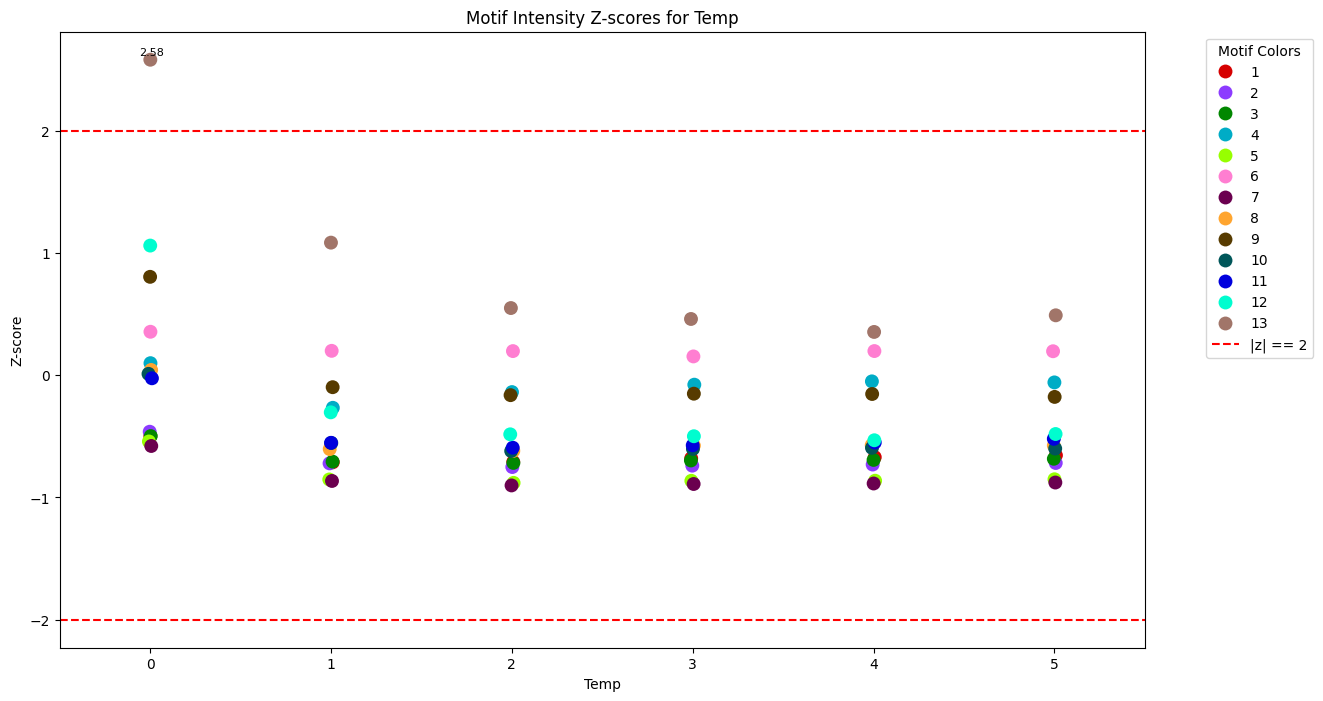

In [312]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
import colorcet as cc

# Plotting: Strip Plot or Box Plot for temp
plt.figure(figsize=(14, 8))
color_palette = sns.color_palette(cc.glasbey, n_colors=temp_temp_df['motif'].nunique())
sns.stripplot(x=nettype, y="zscore", data=temp_temp_df, jitter=0.01, hue="motif", palette=color_palette, size=10)
plt.axhline(y=2, color='red', linestyle='--', label="|z| == 2")
plt.axhline(y=-2, color='red', linestyle='--')
plt.title(f"Motif Intensity Z-scores for {nettype.capitalize()}")
plt.xlabel(nettype.capitalize())
plt.ylabel("Z-score")
plt.legend(title="Motif Colors", bbox_to_anchor=(1.05, 1), loc='upper left')

# Label outliers (stations with |z| > 3 for example)
texts = []
diff = 1 if nettype == 'months' else 0
# outliers = pd.concat([temp_temp_df[temp_temp_df['temp'] == i].nlargest(3, 'zscore') for i in temp_temp_df['temp'].unique()])
# outliers = pd.concat([temp_temp_df[temp_temp_df['percentile'] < 1], temp_temp_df[temp_temp_df['percentile'] > 99]], axis=0)
outliers = temp_temp_df[temp_temp_df['zscore'].abs() >= 2]
for i, row in outliers.iterrows():
    texts.append(plt.text(row[nettype] - diff, row['zscore'], f"{row['zscore']:.2f}", fontsize=8, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.savefig(f'figures/Motifs/RQ1/{nettype}-zscores.png', bbox_inches = 'tight')
plt.show()

In [317]:
nettype = 'temp'

In [318]:
temp_df = df_percentile.loc[:, pd.IndexSlice['years', nettype, :]]
temp_df.columns = temp_df.columns.droplevel([0,1])
temp_temp_df = temp_df.melt(var_name=nettype, value_name='percentile', ignore_index=False).reset_index()
temp_temp_df['percentile'] = temp_temp_df['percentile'].astype(float)

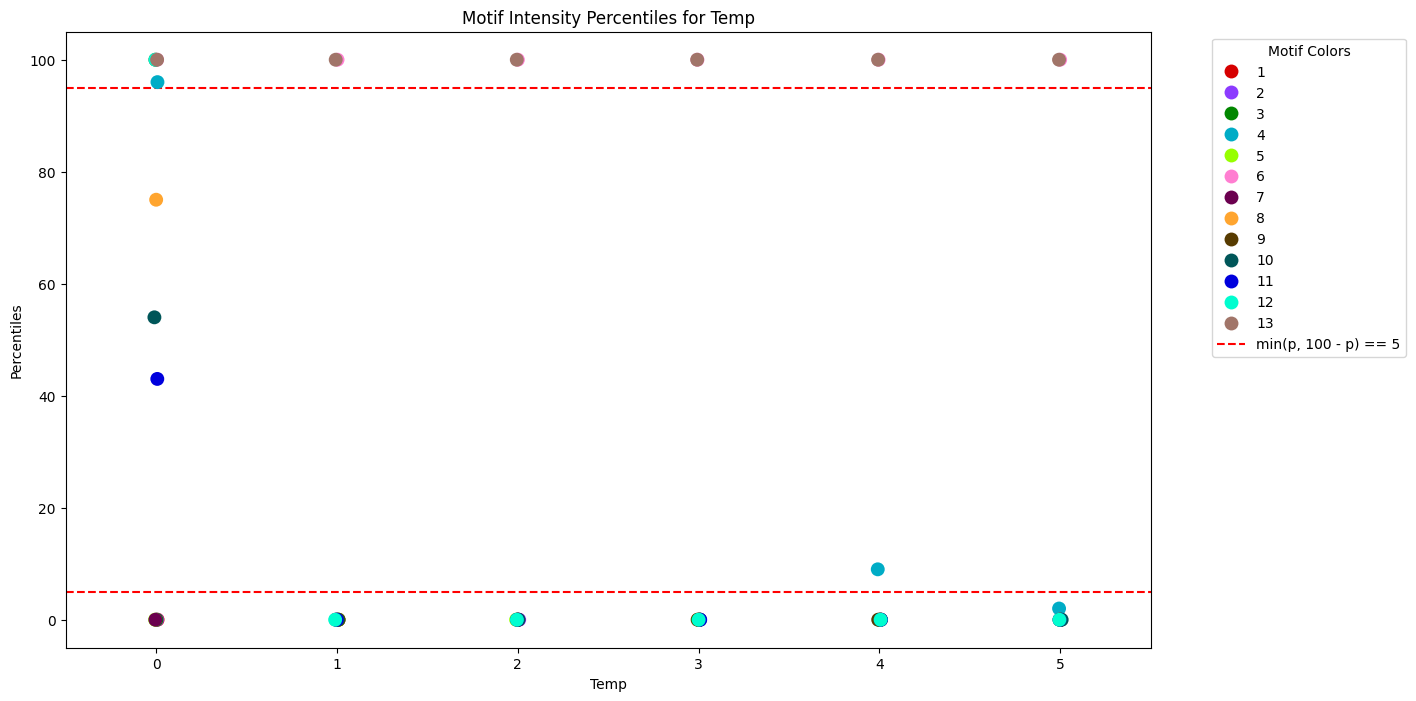

In [319]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
import colorcet as cc

# Plotting: Strip Plot or Box Plot for temp
plt.figure(figsize=(14, 8))
color_palette = sns.color_palette(cc.glasbey, n_colors=temp_temp_df['motif'].nunique())
sns.stripplot(x=nettype, y="percentile", data=temp_temp_df, jitter=0.01, hue="motif", palette=color_palette, size=10)
plt.axhline(y=95, color='red', linestyle='--', label="min(p, 100 - p) == 5")
plt.axhline(y=5, color='red', linestyle='--')
plt.title(f"Motif Intensity Percentiles for {nettype.capitalize()}")
plt.xlabel(nettype.capitalize())
plt.ylabel("Percentiles")
plt.legend(title="Motif Colors", bbox_to_anchor=(1.05, 1), loc='upper left')

# # Label outliers (stations with |z| > 3 for example)
# texts = []
# diff = 1 if nettype == 'temp' else 0
# # outliers = pd.concat([temp_temp_df[temp_temp_df['temp'] == i].nlargest(3, 'percentile') for i in temp_temp_df['temp'].unique()])
# outliers = pd.concat([temp_temp_df[temp_temp_df['percentile'] < 5], temp_temp_df[temp_temp_df['percentile'] > 95]], axis=0)
# for i, row in outliers.iterrows():
#     texts.append(plt.text(row['temp'] - diff, row['percentile'], f"{row['percentile']:.2f}", fontsize=8, ha='center', va='bottom'))

# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.savefig(f'figures/Motifs/RQ1/{nettype}-percentiles.png', bbox_inches = 'tight')
plt.show()

# Motifs - RQ2.1

In [372]:
# df_orig = get_empty_motifs_df()
df_zscore = get_empty_motifs_df()
df_percentile = get_empty_motifs_df()


In [373]:
import itertools
import os
import re
from tqdm.notebook import tqdm
import pickle
import glob

usertypes = ['members', 'casuals', 'years']
nettypes = ['months', 'temp']

file_pattern = re.compile('network(?:-temp)?-(\d{1,2})\.pkl')

for folders in tqdm(list(itertools.product(usertypes, nettypes))):

    usertype, nettype = folders

    folder_path = os.path.join('results','motifs',*folders)

    files = glob.glob(os.path.join(folder_path, '*.pkl'))

    for file in files:
        index_num = int(file_pattern.search(file).group(1))

        with open(file, 'rb') as f:
            result = pickle.load(f)

        motifs, percentiles, z_scores = get_motifs_measures(result)
        
        df_percentile.loc[:, pd.IndexSlice[usertype, nettype, index_num]] = percentiles
        df_zscore.loc[:, pd.IndexSlice[usertype, nettype, index_num]] = z_scores



  0%|          | 0/6 [00:00<?, ?it/s]

In [421]:
nettype = 'months'

In [422]:
temp1 = df_zscore.loc[:, pd.IndexSlice['members', nettype, :]].dropna()
temp1.columns = temp1.columns.droplevel([0, 1])
temp1 = temp1.melt(var_name=nettype, value_name='zscore', ignore_index=False).reset_index()
temp1.name = 'members'

In [423]:
temp2 = df_zscore.loc[:, pd.IndexSlice['casuals', nettype, :]].dropna()
temp2.columns = temp2.columns.droplevel([0, 1])
temp2 = temp2.melt(var_name=nettype, value_name='zscore', ignore_index=False).reset_index()
temp2.name = 'casuals'

In [424]:
temp3 = pd.merge(left=temp1, right=temp2, on=['motif', nettype], suffixes=['_mem', '_cas'])
temp3['diff'] = temp3['zscore_mem'] - temp3['zscore_cas']

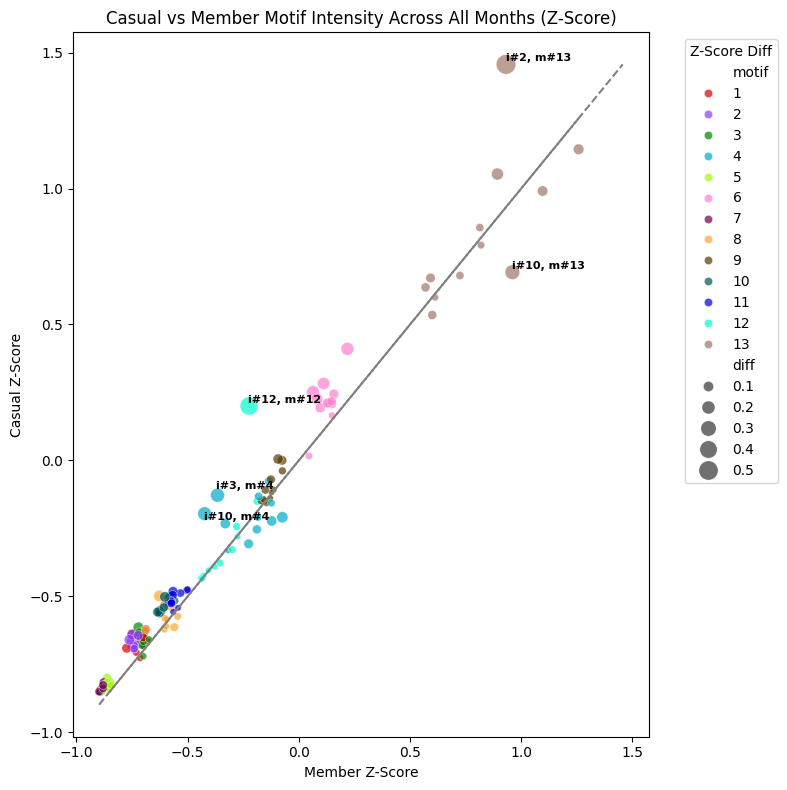

In [425]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from adjustText import adjust_text
import colorcet as cc

color_palette = sns.color_palette(cc.glasbey, n_colors=temp_temp_df['motif'].nunique())

plt.figure(figsize=(8,8))
sns.scatterplot(
    data=temp3,
    x='zscore_mem', 
    y='zscore_cas', 
    hue='motif',
    palette=color_palette,
    size=abs(temp3['diff']),
    sizes=(20, 200),
    alpha=0.7,
    legend=True,
)

# Identity line
# plt.plot([0, 100], [0, 100], linestyle='--', color='gray')
max_m = temp3[['zscore_mem', 'zscore_cas']].max()
min_m = temp3[['zscore_mem', 'zscore_cas']].min()

plt.plot([min_m, max_m], [min_m, max_m], linestyle='--', color='gray')


top_diff = temp3.sort_values('diff',ascending=False,key=abs).head(5)

# Add labels
texts = []
for id, row in top_diff.iterrows():
    texts.append(plt.text(
        row['zscore_mem'],
        row['zscore_cas'],
        f"i#{row[nettype]}, m#{row['motif']}", 
        fontsize=8,
        weight='bold'
    ))

adjust_text(texts, force_text=1.5, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.xlabel("Member Z-Score")
plt.ylabel("Casual Z-Score")
plt.title(f"Casual vs Member Motif Intensity Across All {nettype.capitalize()} (Z-Score)")
plt.legend(title='Z-Score Diff', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'figures/Motifs/RQ2.1/usercomp-{nettype}-zscores.png', bbox_inches = 'tight')
plt.show()



# Motifs - RQ3

In [450]:
df_orig = get_empty_motifs_df()
df_zscore = get_empty_motifs_df()
df_percentile = get_empty_motifs_df()


In [451]:
import itertools
import os
import re
from tqdm.notebook import tqdm
import pickle
import glob

usertypes = ['members', 'casuals', 'years']
nettypes = ['months', 'temp']

file_pattern = re.compile('network(?:-temp)?-(\d{1,2})\.pkl')

for folders in tqdm(list(itertools.product(usertypes, nettypes))):

    usertype, nettype = folders

    folder_path = os.path.join('results','motifs',*folders)

    files = glob.glob(os.path.join(folder_path, '*.pkl'))

    for file in files:
        index_num = int(file_pattern.search(file).group(1))

        with open(file, 'rb') as f:
            result = pickle.load(f)

        motifs, percentiles, z_scores = get_motifs_measures(result)

        df_orig.loc[:, pd.IndexSlice[usertype, nettype, index_num]] = motifs
        df_percentile.loc[:, pd.IndexSlice[usertype, nettype, index_num]] = percentiles
        df_zscore.loc[:, pd.IndexSlice[usertype, nettype, index_num]] = z_scores



  0%|          | 0/6 [00:00<?, ?it/s]

In [452]:
df_casuals = df_zscore.loc[:, pd.IndexSlice['casuals', 'months', :]]
df_casuals.columns = df_casuals.columns.droplevel([0,1])

df_members = df_zscore.loc[:, pd.IndexSlice['members', 'months', :]]
df_members.columns = df_members.columns.droplevel([0,1])

In [453]:
motif = 1

temp_casuals = df_casuals.loc[motif]
temp_casuals.name = 'casuals'

temp_members = df_members.loc[motif]
temp_members.name = 'members'

temp_df = pd.concat([temp_members, temp_casuals], axis=1)

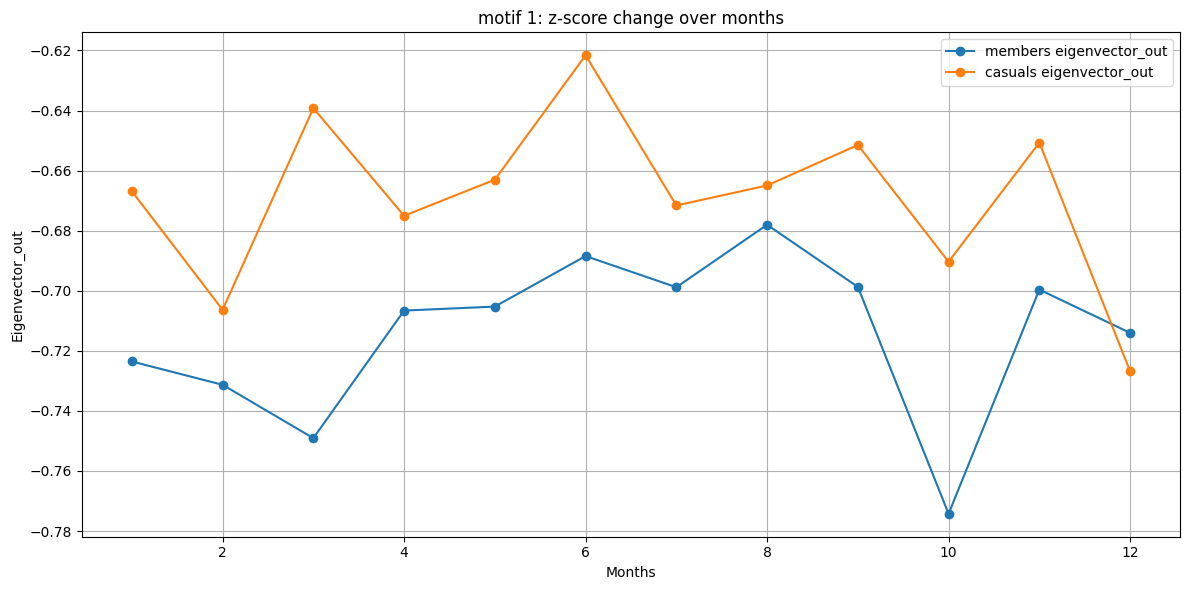

In [455]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

usertypes = ['members', 'casuals']
nettypes = ['months', 'temp']

nettype = 'months'

for user in usertypes:
    plt.plot(temp_df.index, temp_df[user], label=f'{user} {centrality}', marker='o')
    

plt.xlabel(f'{nettype}'.capitalize())
plt.ylabel(f'{centrality}'.capitalize())
plt.title(f'motif {motif}: z-score change over {nettype}')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('figures/RQ2.3/usercompar-efficiency-months.png', bbox_inches = 'tight')
plt.show()


In [456]:
usertypes = ['members', 'casuals']
nettypes = ['months', 'temp']

for used_df, name in [(df_orig, 'intensity'), (df_zscore, 'z-score'), (df_percentile, 'percentile')]:

    for nettype in nettypes:

        df_casuals = used_df.loc[:, pd.IndexSlice['casuals', nettype, :]]
        df_casuals.columns = df_casuals.columns.droplevel([0,1])
        
        df_members = used_df.loc[:, pd.IndexSlice['members', nettype, :]]
        df_members.columns = df_members.columns.droplevel([0,1])

        for motif_id in range(1, 14):

            temp_casuals = df_casuals.loc[motif_id]
            temp_casuals.name = 'casuals'
            
            temp_members = df_members.loc[motif_id]
            temp_members.name = 'members'
            
            temp_df = pd.concat([temp_members, temp_casuals], axis=1)

            plt.figure(figsize=(12,6))
            
            for user in usertypes:
                plt.plot(temp_df.index, temp_df[user], label=f'{user} {name}', marker='o')
                
            
            plt.xlabel(f'{nettype}'.capitalize())
            plt.ylabel(f'{name}'.capitalize())
            plt.title(f'motif {motif_id}: {name} change over {nettype}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'figures/Motifs/RQ3/{name}/{nettype}/condition-motif_{motif_id}.png', bbox_inches = 'tight')
            # plt.show()
            plt.close()